In [1]:
# Titanic 幸存者预测案例          3/21

>**基本思路**：
1 使用可视化、相关矩阵等方法，探索并假设相关变量。\
2 使用统计学方法（如卡方检验）等方法对之前的假设相关变量进行确定。\
3 在确定特征变量的前提下，使用逻辑回归方法进行建模。\
4 使用Gridsearch 进行参数调整。


In [2]:
#### 导入相关库和文件

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data_train=pd.read_csv("c:/csv/train_titanic.csv")


In [3]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 1 探索并假设相关变量
> 这个阶段的主要任务包括：\
1 分析目标变量\
2 通过各种手段，假设相关变量并进行分析和确认；\
3 对多缺失值变量进行处理；\
4 新建相关变量

In [6]:
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

>***注意到***：整个数据集里面的Age和Cabin有大量的缺失值,首先要填充缺失值。

#### 1.1 填充缺失值部分\
*先看一下整个age的分布情况*

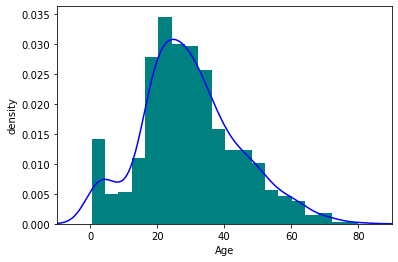

In [4]:
#Age 缺失值填充
ax=data_train['Age'].hist(bins=20,density=True,stacked=True,color='teal')
data_train['Age'].plot(kind='density',color='blue')
ax.set(xlabel='Age',ylabel='density')
plt.xlim(-10,90)
plt.show()

In [8]:
data_train['Age'].median()

28.0

In [5]:
data_train['Age'].mean()

29.69911764705882

><font color="#dd0000">fillna() 是median(),括号不要忘记!</font><br /> 

In [6]:
data_train['Age'].fillna(data_train['Age'].median(),inplace=True)  

>*结论*：\
1 Age的分布有偏态的。\
2 偏态情况下，均值和中位值是不同的；\
3 本例中，均值和中位数大小相差不大，用谁填充均可。

In [7]:
data_train['Age'].isnull().sum()

0

In [8]:
data_train['Cabin'].isnull().sum()

687

>*结论*：
Cabin特征缺失值太多，填充的意义并不大，直接删除此列。

In [9]:
data_train.drop(['Cabin'],axis=1,inplace=True)

In [16]:
mode_num=data_train['Embarked'].mode()   # 求本列的众数
mode_num

0    S
dtype: object

In [10]:
#Embarked 特征的缺失值,众数填充
data_train['Embarked'].fillna('S',inplace=True)

In [18]:
data_train['Embarked'].isnull().sum()

0

In [11]:
data_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

> ***至此，缺失值部分已经处理完成***

#### 1.2 特征值分析：

1 除去PID和目标变量Survived 以外，共有10个特征值。\
2 10个特征中，共有5个分类变量，即：Pclass，Sex，Embarked，Sibsp，Parch。\
3 共3个连续型变量，即：Age，Sibsp(随行亲属数量)，Ticket，Fare。



| 变量类型   | 变量名称  |
|  ----  | ----  |
| 分类  |Pclass |
| 分类  | Sex |
| 分类  | Embarked |
| 分类  | Sibsp |

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

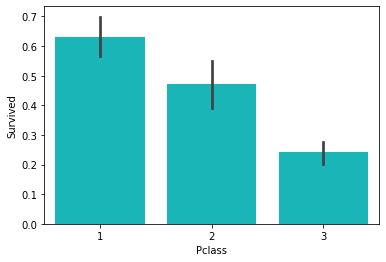

In [12]:
sns.barplot("Pclass","Survived",data=data_train,color="darkturquoise")

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

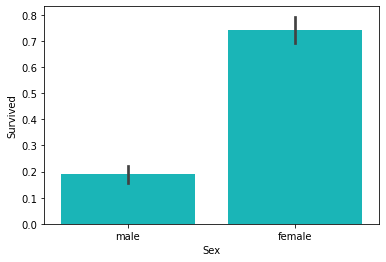

In [13]:
sns.barplot("Sex","Survived",data=data_train,color="darkturquoise")

In [22]:
data_train.groupby("Sex")['Survived'].sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [14]:
data_train['Embarked'].isnull().sum()

0

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

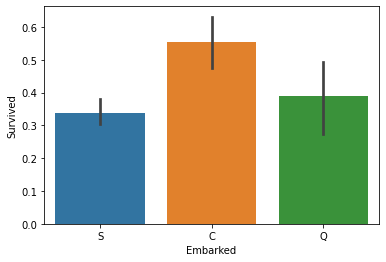

In [15]:
sns.barplot('Embarked', 'Survived', data=data_train)

In [16]:
data_train['TravelAlone']= np.where((data_train["SibSp"]+data_train["Parch"])>0, 0, 1)

In [17]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TravelAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1


In [27]:
data_train.drop('SibSp', axis=1, inplace=True)
data_train.drop('Parch', axis=1, inplace=True)

>删除"sibSp"和 "Parch"两个变量

<AxesSubplot:xlabel='TravelAlone', ylabel='Survived'>

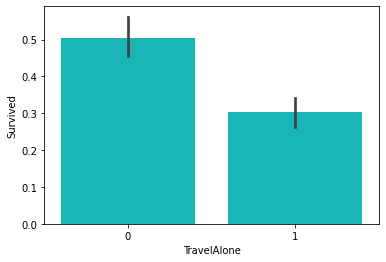

In [28]:
sns.barplot("TravelAlone","Survived",data=data_train,color="darkturquoise")

> ***结论：从上面可见，Pclass，Sex,Embarked,TravelAlone 都是和目标变量相关的特征变量。***

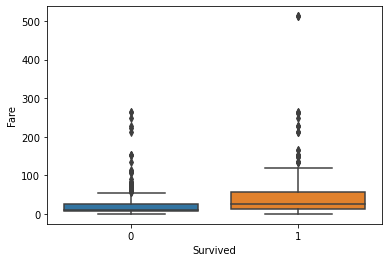

In [18]:
fig=sns.boxplot(x="Survived",y="Fare",data=data_train)
#fig.axis(ymin=0,ymax=512)

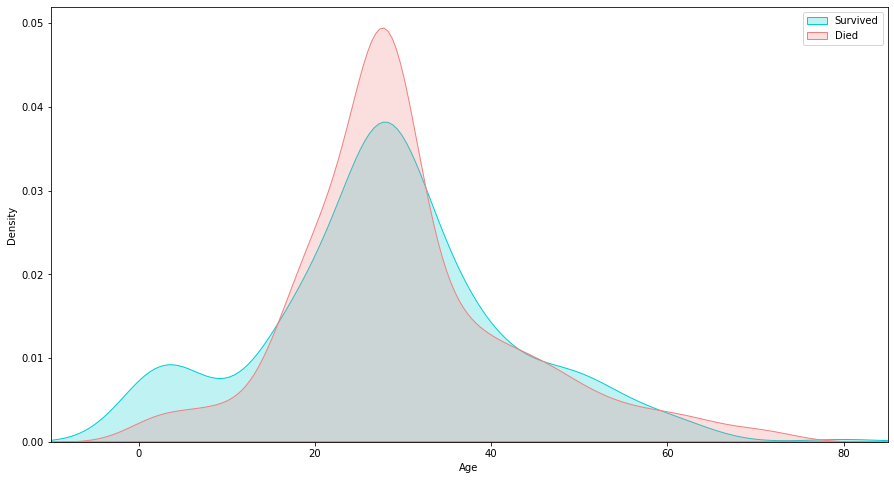

In [19]:
plt.figure(figsize=(15,8))

ax=sns.kdeplot(data_train["Age"][data_train.Survived==1],color="darkturquoise",shade=True)
sns.kdeplot(data_train["Age"][data_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()


>***结论：***\
1 “Survived"为1的样本群，其对应的Fare的中位数和最大值都明显高于Survived为0的样本。\
2 死亡和幸存的年龄分布很类似，峰值都集中在20-40这个年龄段中。\
3 相比死亡人群，幸存者的儿童(年龄小于15+）比例相对更多。

### 1.3 分类特征变量处理

In [20]:
features=['PassengerId','Survived','Pclass','Sex','Age','Fare','Embarked','TravelAlone']

In [21]:
data_train_vars=data_train[features]
data_train_vars

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,TravelAlone
0,1,0,3,male,22.0,7.2500,S,0
1,2,1,1,female,38.0,71.2833,C,0
2,3,1,3,female,26.0,7.9250,S,1
3,4,1,1,female,35.0,53.1000,S,0
4,5,0,3,male,35.0,8.0500,S,1
...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,13.0000,S,1
887,888,1,1,female,19.0,30.0000,S,1
888,889,0,3,female,28.0,23.4500,S,0
889,890,1,1,male,26.0,30.0000,C,1


> ***将相关特征变量分类型的进行one-hot转换***

In [24]:
data_train_final=pd.get_dummies(data_train_vars, columns=["Pclass","Embarked","Sex"])

In [25]:
data_train_final

,PassengerId,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,22.0,7.2500,0,0,0,1,0,0,1,0,1
1,2,1,38.0,71.2833,0,1,0,0,1,0,0,1,0
2,3,1,26.0,7.9250,1,0,0,1,0,0,1,1,0
3,4,1,35.0,53.1000,0,1,0,0,0,0,1,1,0
4,5,0,35.0,8.0500,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.0,13.0000,1,0,1,0,0,0,1,0,1
887,888,1,19.0,30.0000,1,1,0,0,0,0,1,1,0
888,889,0,28.0,23.4500,0,0,0,1,0,0,1,1,0
889,890,1,26.0,30.0000,1,1,0,0,1,0,0,0,1


In [ ]:
>对于分类变量，由于都是同一数据，故可以删除分类后的多余变量。\
此处删除去Pclass_2,Pclass_3，Embarked_Q,Embarked_S,Sex_male.

In [26]:
data_train_final.drop(columns=[ "Pclass_2","Pclass_3","Embarked_Q","Embarked_S","Sex_male"],axis=1,inplace=True)

In [27]:
data_train_final

,PassengerId,Survived,Age,Fare,TravelAlone,Pclass_1,Embarked_C,Sex_female
0,1,0,22.0,7.2500,0,0,0,0
1,2,1,38.0,71.2833,0,1,1,1
2,3,1,26.0,7.9250,1,0,0,1
3,4,1,35.0,53.1000,0,1,0,1
4,5,0,35.0,8.0500,1,0,0,0
...,...,...,...,...,...,...,...,...
886,887,0,27.0,13.0000,1,0,0,0
887,888,1,19.0,30.0000,1,1,0,1
888,889,0,28.0,23.4500,0,0,0,1
889,890,1,26.0,30.0000,1,1,1,0


>*** 相关系数更多的体现在线性相关关系上，使用在此处并不完全合适，以下步骤可以略去。***

<AxesSubplot:>

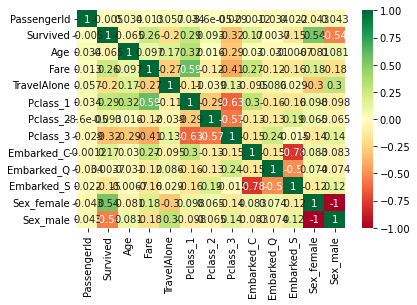

In [36]:
sns.heatmap(data_train_final.corr(),annot=True, cmap="RdYlGn")

In [37]:
data_train_final.corr()

,PassengerId,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
PassengerId,1.000000,-0.005007,0.034212,0.012658,0.057462,0.034303,-0.000086,-0.029486,-0.001205,-0.033606,0.022204,-0.042939,0.042939
Survived,-0.005007,1.000000,-0.064910,0.257307,-0.203367,0.285904,0.093349,-0.322308,0.168240,0.003650,-0.149683,0.543351,-0.543351
Age,0.034212,-0.064910,1.000000,0.096688,0.171647,0.323896,0.015831,-0.291955,0.030248,-0.031415,-0.006729,-0.081163,0.081163
Fare,0.012658,0.257307,0.096688,1.000000,-0.271832,0.591711,-0.118557,-0.413333,0.269335,-0.117216,-0.162184,0.182333,-0.182333
TravelAlone,0.057462,-0.203367,0.171647,-0.271832,1.000000,-0.113364,-0.039070,0.129472,-0.095298,0.086464,0.029074,-0.303646,0.303646
Pclass_1,0.034303,0.285904,0.323896,0.591711,-0.113364,1.000000,-0.288585,-0.626738,0.296423,-0.155342,-0.161921,0.098013,-0.098013
Pclass_2,-0.000086,0.093349,0.015831,-0.118557,-0.039070,-0.288585,1.000000,-0.565210,-0.125416,-0.127301,0.189980,0.064746,-0.064746
Pclass_3,-0.029486,-0.322308,-0.291955,-0.413333,0.129472,-0.626738,-0.565210,1.000000,-0.153329,0.237449,-0.015104,-0.137143,0.137143
Embarked_C,-0.001205,0.168240,0.030248,0.269335,-0.095298,0.296423,-0.125416,-0.153329,1.000000,-0.148258,-0.782742,0.082853,-0.082853
Embarked_Q,-0.033606,0.003650,-0.031415,-0.117216,0.086464,-0.155342,-0.127301,0.237449,-0.148258,1.000000,-0.499421,0.074115,-0.074115


In [38]:
data_train_final.columns

Index(['PassengerId', 'Survived', 'Age', 'Fare', 'TravelAlone', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male'],
      dtype='object')

>***结论:从相关系数矩阵，选择4个或者5个特征值（one-hot变量，都是同一变量，可以随意选择），分别为\
"Fare","Pclass_1","Embarked_C","Sex_female,'TravelAlone'"***

>________如上步骤忽略不执行________________

In [28]:
data_train_final

,PassengerId,Survived,Age,Fare,TravelAlone,Pclass_1,Embarked_C,Sex_female
0,1,0,22.0,7.2500,0,0,0,0
1,2,1,38.0,71.2833,0,1,1,1
2,3,1,26.0,7.9250,1,0,0,1
3,4,1,35.0,53.1000,0,1,0,1
4,5,0,35.0,8.0500,1,0,0,0
...,...,...,...,...,...,...,...,...
886,887,0,27.0,13.0000,1,0,0,0
887,888,1,19.0,30.0000,1,1,0,1
888,889,0,28.0,23.4500,0,0,0,1
889,890,1,26.0,30.0000,1,1,1,0


> ***1.4 要把Age和Fare 两个特征变量做归一化处理***。

In [29]:
oth_cols=data_train_final.iloc[:,4:]
oth_cols

,TravelAlone,Pclass_1,Embarked_C,Sex_female
0,0,0,0,0
1,0,1,1,1
2,1,0,0,1
3,0,1,0,1
4,1,0,0,0
...,...,...,...,...
886,1,0,0,0
887,1,1,0,1
888,0,0,0,1
889,1,1,1,0


In [30]:
x_age_fare=data_train_final.iloc[:,2:4]
#x_age_fare_scale=x_fare.values.reshape(-1,1)
x_age_fare

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
886,27.0,13.0000
887,19.0,30.0000
888,28.0,23.4500
889,26.0,30.0000


In [31]:
age_fare_scaled = preprocessing.StandardScaler().fit(x_age_fare)
age_fare_result= age_fare_scaled.transform(x_age_fare)
age_fare_result

array([[-0.56573646, -0.50244517],
       [ 0.66386103,  0.78684529],
       [-0.25833709, -0.48885426],
       ...,
       [-0.1046374 , -0.17626324],
       [-0.25833709, -0.04438104],
       [ 0.20276197, -0.49237783]])

In [33]:
age_fare_resultt=pd.DataFrame(age_fare_result)
age_fare_resultt.columns=['Age','Fare']
age_fare_resultt

,Age,Fare
0,-0.565736,-0.502445
1,0.663861,0.786845
2,-0.258337,-0.488854
3,0.433312,0.420730
4,0.433312,-0.486337
...,...,...
886,-0.181487,-0.386671
887,-0.796286,-0.044381
888,-0.104637,-0.176263
889,-0.258337,-0.044381


In [34]:
X_train=pd.concat([age_fare_resultt,oth_cols],axis=1)
X_train

,Age,Fare,TravelAlone,Pclass_1,Embarked_C,Sex_female
0,-0.565736,-0.502445,0,0,0,0
1,0.663861,0.786845,0,1,1,1
2,-0.258337,-0.488854,1,0,0,1
3,0.433312,0.420730,0,1,0,1
4,0.433312,-0.486337,1,0,0,0
...,...,...,...,...,...,...
886,-0.181487,-0.386671,1,0,0,0
887,-0.796286,-0.044381,1,1,0,1
888,-0.104637,-0.176263,0,0,0,1
889,-0.258337,-0.044381,1,1,1,0


### 1.5 最终特征变量的确定

In [37]:
y_train=data_train_final['Survived']
y_train.shape

(891,)

In [39]:
X_train.shape

(891, 6)

#  2 逻辑回归进行训练

### 2.1 训练模型

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train)

In [47]:
lgr=LogisticRegression(penalty='l2',C=0.1)
model=lgr.fit(X_train,y_train)
print('模型','n',model)
print('模型系数:',model.coef_)
print('模型截距:',model.intercept_)
print('模型得分:',model.score(X_test,y_test))


模型 n LogisticRegression(C=0.1)
模型系数: [[-0.21344419  0.26515695 -0.0338025   0.71203195  0.32159984  1.81313714]]
模型截距: [-1.37661329]
模型得分: 0.7847533632286996


In [48]:
y_predict = model.predict(X_test)  #打印真实值与预测值


In [49]:
y_predict

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0], dtype=int64)

In [50]:
y_predict_df = pd.DataFrame(y_predict,columns=['y_predict'],index=y_test.index)
y_test_predict_df = pd.concat([y_test,y_predict_df],axis = 1)
print('真实值与预测值',y_test_predict_df)

真实值与预测值      Survived  y_predict
823         1          1
500         0          0
846         0          0
28          1          1
291         1          1
..        ...        ...
646         0          0
535         1          1
776         0          0
751         1          0
707         1          0

[223 rows x 2 columns]


In [51]:
accuracy = metrics.accuracy_score(y_test, y_predict)
confusionmatrix = metrics.confusion_matrix(y_test, y_predict)
target_names = ['Label 0', 'Label 1']
classifyreport = metrics.classification_report(y_test, y_predict,target_names=target_names)
print('分类准确率 ',accuracy) # 混淆矩阵对角线元素之和/所有元素之和
print('混淆矩阵 n', confusionmatrix)
print('分类结果报告 n', classifyreport)

分类准确率  0.7847533632286996
混淆矩阵 n [[118  23]
 [ 25  57]]
分类结果报告 n               precision    recall  f1-score   support

     Label 0       0.83      0.84      0.83       141
     Label 1       0.71      0.70      0.70        82

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



In [52]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict,pos_label=1)  #
auc = metrics.auc(fpr, tpr)
fpr,tpr

(array([0.        , 0.16312057, 1.        ]),
 array([0.        , 0.69512195, 1.        ]))

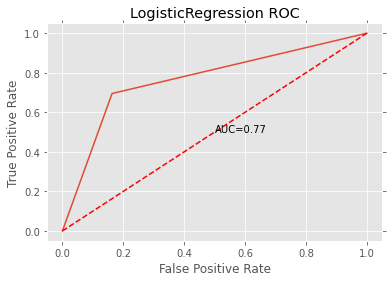

In [53]:
plt.style.use('ggplot')   #设置绘图风格
plt.plot(fpr, tpr,'')    #绘制ROC曲线
plt.plot((0,1),(0,1),'r--')   #绘制参考线
plt.text(0.5,0.5,'AUC=%.2f' %auc)   #添加文本注释
plt.title('LogisticRegression ROC')  #设置标题
plt.xlabel('False Positive Rate')   #设置坐标轴标签
plt.ylabel('True Positive Rate')
plt.tick_params(top='off', right='off') #去除图形顶部边界和右边界的刻度
plt.show()  

### 2.1 使用GridSearchCV（）寻求最佳参数

In [54]:
parameters = {'penalty': ('l1', 'l2'),'C': (0.01, 0.1, 0.5,1, 10)}
grid_search = GridSearchCV(LogisticRegression(), parameters,  verbose=0, scoring='accuracy', cv=5)
grid =grid_search.fit(X_train, y_train)
print('最佳效果：%0.3f' % grid_search.best_score_)
best_parameters= grid_search.best_estimator_.get_params()
print('最佳参数：n', best_parameters)


最佳效果：0.786
最佳参数：n {'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [55]:
best_parameters

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

> *参数说明：https://blog.csdn.net/jark_/article/details/78342644*

### 2.2 使用最优参数，重新训练模型。

In [56]:
lgr1=LogisticRegression(penalty='l2',C=0.5)
model_1=lgr1.fit(X_train,y_train)
print('模型','n',model_1)
print('模型系数:',model_1.coef_)
print('模型截距:',model_1.intercept_)
print('模型得分:',model_1.score(X_test,y_test))


模型 n LogisticRegression(C=0.5)
模型系数: [[-0.28061141  0.17035241  0.06859378  1.15710985  0.42645651  2.37225028]]
模型截距: [-1.80068069]
模型得分: 0.7847533632286996


In [62]:
X_train

,Age,Fare,TravelAlone,Pclass_1,Embarked_C,Sex_female
597,1.509209,-0.648422,1,0,0,0
32,-0.104637,-0.492378,1,0,0,1
83,-0.104637,0.299922,1,1,0,0
801,0.125912,-0.119886,0,0,0,1
612,-0.104637,-0.336334,0,0,0,1
...,...,...,...,...,...,...
322,0.049062,-0.399758,1,0,0,1
414,1.124960,-0.488854,1,0,0,0
825,-0.104637,-0.508486,1,0,0,0
399,-0.104637,-0.393718,1,0,0,1


# 3 在测试集中应用模型，进行预测

### 3.1 先将测试集按照训练集的方法，进行数据特征处理

In [58]:
data_test = pd.read_csv("c:/csv/test_titanic.csv")
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [59]:
data_test_final=pd.get_dummies(data_test, columns=["Pclass","Embarked","Sex"])
data_test_final

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,0,1,0,1,0,0,1
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,0,0,1,0,0,1,1,0
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,0,1,0,0,1
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,0,1,0,0,1,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,0,0,1,0,0,1,0,1
414,1306,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,0,0,1,0,0,1,0
415,1307,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,0,1,0,0,1,0,1
416,1308,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,0,0,1,0,0,1,0,1


In [60]:
data_test_final['TravelAlone']= np.where((data_test_final["SibSp"]+data_test_final["Parch"])>0, 0, 1)

In [61]:
data_test_final.drop(columns=['Name','Ticket','Cabin','Pclass_2','Pclass_3','Embarked_Q','Embarked_S',"SibSp","Parch","Sex_male"],axis=1,inplace=True)
data_test_final

,PassengerId,Age,Fare,Pclass_1,Embarked_C,Sex_female,TravelAlone
0,892,34.5,7.8292,0,0,0,1
1,893,47.0,7.0000,0,0,1,0
2,894,62.0,9.6875,0,0,0,1
3,895,27.0,8.6625,0,0,0,1
4,896,22.0,12.2875,0,0,1,0
...,...,...,...,...,...,...,...
413,1305,NaN,8.0500,0,0,0,1
414,1306,39.0,108.9000,1,1,1,1
415,1307,38.5,7.2500,0,0,0,1
416,1308,NaN,8.0500,0,0,0,1


In [63]:
data_test_final['Age'].fillna(data_test_final['Age'].median(),inplace=True)

In [64]:
data_test_final

,PassengerId,Age,Fare,Pclass_1,Embarked_C,Sex_female,TravelAlone
0,892,34.5,7.8292,0,0,0,1
1,893,47.0,7.0000,0,0,1,0
2,894,62.0,9.6875,0,0,0,1
3,895,27.0,8.6625,0,0,0,1
4,896,22.0,12.2875,0,0,1,0
...,...,...,...,...,...,...,...
413,1305,27.0,8.0500,0,0,0,1
414,1306,39.0,108.9000,1,1,1,1
415,1307,38.5,7.2500,0,0,0,1
416,1308,27.0,8.0500,0,0,0,1


In [69]:
data_test_final['Fare'].fillna(data_test_final['Fare'].median(),inplace=True)

In [70]:
data_test_final.isnull().sum()

PassengerId    0
Age            0
Fare           0
Pclass_1       0
Embarked_C     0
Sex_female     0
TravelAlone    0
dtype: int64

In [72]:
x_test_final=data_test_final.iloc[:,1:]

In [73]:
x_test_final

,Age,Fare,Pclass_1,Embarked_C,Sex_female,TravelAlone
0,34.5,7.8292,0,0,0,1
1,47.0,7.0000,0,0,1,0
2,62.0,9.6875,0,0,0,1
3,27.0,8.6625,0,0,0,1
4,22.0,12.2875,0,0,1,0
...,...,...,...,...,...,...
413,27.0,8.0500,0,0,0,1
414,39.0,108.9000,1,1,1,1
415,38.5,7.2500,0,0,0,1
416,27.0,8.0500,0,0,0,1


### 3.2 对连续型变量(Age和Fare）进行归一化处理

In [86]:
test_age_fare=x_test_final.iloc[:,0:2]
test_others=x_test_final.iloc[:,2:]
test_age_fare

,Age,Fare
0,34.5,7.8292
1,47.0,7.0000
2,62.0,9.6875
3,27.0,8.6625
4,22.0,12.2875
...,...,...
413,27.0,8.0500
414,39.0,108.9000
415,38.5,7.2500
416,27.0,8.0500


In [87]:
test_others

,Pclass_1,Embarked_C,Sex_female,TravelAlone
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,1,0
...,...,...,...,...
413,0,0,0,1
414,1,1,1,1
415,0,0,0,1
416,0,0,0,1


In [82]:
agefare_scaled = preprocessing.StandardScaler().fit(test_age_fare)
agefare_test= age_fare_scaled.transform(test_age_fare)
agefare_test

array([[ 3.94886580e-01, -4.90783161e-01],
       [ 1.35550962e+00, -5.07478843e-01],
       [ 2.50825727e+00, -4.53366871e-01],
       [-1.81487244e-01, -4.74004926e-01],
       [-5.65736461e-01, -4.01016685e-01],
       [-1.18053521e+00, -4.62679164e-01],
       [ 4.90622855e-02, -4.94810098e-01],
       [-2.58337088e-01, -6.45157251e-02],
       [-8.73135834e-01, -5.02863973e-01],
       [-6.42586304e-01, -1.62168958e-01],
       [-1.81487244e-01, -4.89442190e-01],
       [ 1.27865978e+00, -1.24919787e-01],
       [-4.88886618e-01,  1.00799262e+00],
       [ 2.58510712e+00, -1.24919787e-01],
       [ 1.35550962e+00,  5.83317835e-01],
       [-4.12036774e-01, -9.02720170e-02],
       [ 4.33311502e-01, -3.99758267e-01],
       [-6.42586304e-01, -5.02948539e-01],
       [-1.81487244e-01, -4.88854258e-01],
       [ 1.20180994e+00, -5.02948539e-01],
       [ 1.97030837e+00,  5.47578765e-01],
       [-1.56478442e+00, -5.84578587e-01],
       [-1.81487244e-01, -1.04883190e-02],
       [-6.

In [85]:
age_fare_test=pd.DataFrame(agefare_test)
age_fare_test.columns=['Age','Fare']
age_fare_test

,Age,Fare
0,0.394887,-0.490783
1,1.355510,-0.507479
2,2.508257,-0.453367
3,-0.181487,-0.474005
4,-0.565736,-0.401017
...,...,...
413,-0.181487,-0.486337
414,0.740711,1.544246
415,0.702286,-0.502445
416,-0.181487,-0.486337


In [88]:
X_test=pd.concat([age_fare_test,test_others],axis=1)
X_test

,Age,Fare,Pclass_1,Embarked_C,Sex_female,TravelAlone
0,0.394887,-0.490783,0,0,0,1
1,1.355510,-0.507479,0,0,1,0
2,2.508257,-0.453367,0,0,0,1
3,-0.181487,-0.474005,0,0,0,1
4,-0.565736,-0.401017,0,0,1,0
...,...,...,...,...,...,...
413,-0.181487,-0.486337,0,0,0,1
414,0.740711,1.544246,1,1,1,1
415,0.702286,-0.502445,0,0,0,1
416,-0.181487,-0.486337,0,0,0,1


In [90]:
y_test_pred=lgr1.predict(X_test)

In [93]:
y_test_pred

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

In [94]:
X_test_pred=pd.DataFrame(y_test_pred)

In [97]:
X_test_pred.columns=["Survived"]
X_test_pred

,Survived
0,1
1,0
2,0
3,1
4,0
...,...
413,1
414,1
415,1
416,1


In [102]:
final_result=pd.concat([data_test["PassengerId"],X_test_pred],axis=1)
final_result

,PassengerId,Survived
0,892,1
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1


In [103]:
final_result.to_csv("c:/csv/Tiannic_PredicationResult.csv")

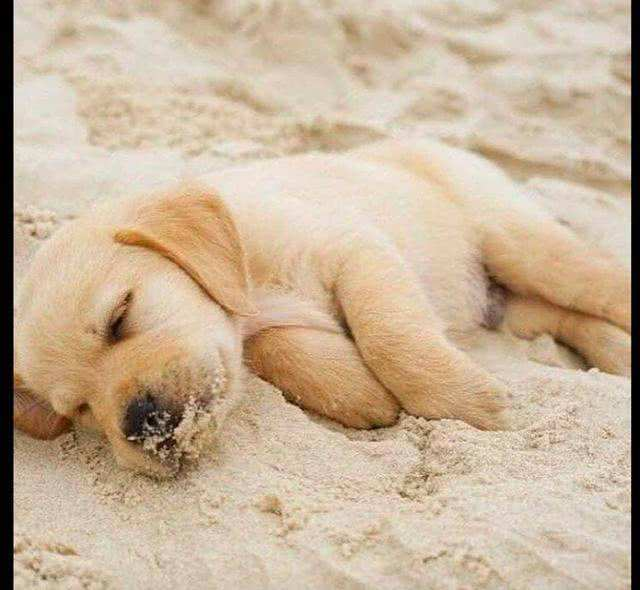